In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from functools import partial
import scipy.stats

from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
result_list = []
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv', index_col='id')
test = pd.read_csv('/kaggle/input/dissolved-oxygen-prediction-in-river-water/test.csv', index_col='Id')
sample_submission.target = sample_submission.target.clip(6, 18)

# Baseline model

In [3]:
%%time

def score_competition(submission, validation):
    """Simulate the scoring of a submission against the test set
    
    Return the validation MAE"""
    y_train = submission.pop('target')
    rf = RandomForestRegressor(n_estimators=1000,
                               max_depth=7,
                               n_jobs=-1,
                               random_state=42)
    rf.fit(submission, y_train)
    y_va_pred = rf.predict(validation.iloc[:, 1:])
    mae = mean_absolute_error(validation.iloc[:, 0], y_va_pred)
    return mae

def cross_validate_model(prepare_submission, label):
    """Cross-validate the prepare_submission function
    
    prepare_submission transforms its argument sample_submission
    into the submitted training data""" 
    mae_list = []
    kf = KFold(shuffle=True, random_state=1)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(sample_submission)):
        submission = prepare_submission(sample_submission.iloc[idx_tr].copy())
        mae = score_competition(submission, sample_submission.iloc[idx_va])
        print(f"# Fold {fold} MSE: {mae:.3f}")
        mae_list.append(mae)

    mae = np.array(mae_list).mean()
    print(f"# Overall MSE: {mae:.3f} {label}")
    result_list.append((label, mae))
    
cross_validate_model(lambda x: x, 'baseline')

# Fold 0 MSE: 0.748
# Fold 1 MSE: 0.710
# Fold 2 MSE: 0.732
# Fold 3 MSE: 0.711
# Fold 4 MSE: 0.730
# Overall MSE: 0.726 baseline
CPU times: user 2min 35s, sys: 1.55 s, total: 2min 37s
Wall time: 45 s


# Improving the dataset | Dropping Noise Columns 

In [7]:
%%time
# features = ['O2_1', 'O2_2', 'O2_3']
features = ['O2_1', 'O2_2', 'BOD5_5']
def drop_except(submission, features):
    """Overwrites all other features with zeros and returns the submission dataframe"""
    for col in test.columns:
        if col not in features:
            submission[col] = 0
    return submission
        
cross_validate_model(partial(drop_except, features=features), f'only {features}')

# Fold 0 MSE: 0.743
# Fold 1 MSE: 0.706
# Fold 2 MSE: 0.719
# Fold 3 MSE: 0.714
# Fold 4 MSE: 0.711
# Overall MSE: 0.718 only ['O2_1', 'O2_2', 'BOD5_5']
CPU times: user 26.9 s, sys: 1.99 s, total: 28.9 s
Wall time: 19.5 s


# Improving the dataset | Clipping the target

In [146]:
%%time
features = ['O2_1', 'O2_2', 'O2_4', 'NO2_2', 'NH4_2']
def select_and_clip(submission, features, lower, upper):
    """Select features and clip the target to the given bounds"""
    submission = drop_except(submission, features)
    submission['target'] = submission['target'].clip(lower, upper)
    return submission
        
cross_validate_model(partial(select_and_clip, features=features, lower=6, upper=16),
                     f'only {features} with clipped target')

# Fold 0 MAE: 0.725
# Fold 1 MAE: 0.692
# Fold 2 MAE: 0.708
# Fold 3 MAE: 0.711
# Fold 4 MAE: 0.708
# Overall MAE: 0.709 only ['O2_1', 'O2_2', 'O2_4', 'NO2_2', 'NH4_2'] with clipped target
CPU times: user 24.9 s, sys: 1.62 s, total: 26.5 s
Wall time: 15.5 s


# Improving the dataset | Psuedo Labeling 

In [8]:
%%time
def apply_rf_pseudolabeling(submission, features):
    """Select features and pseudolabel the targets with a random forest"""
    submission = drop_except(submission, features)
    
    # Compute the pseudolabels
    rf1 = RandomForestRegressor(
           n_estimators=1500,
           criterion='squared_error',
           max_depth=7,
           n_jobs=-1,
           random_state=42)
    rf1.fit(submission.iloc[:,1:], submission.iloc[:,0])
    submission['target'] = rf1.predict(submission.iloc[:,1:]) # pseudolabels
    return submission
    
features = ['O2_1', 'O2_2', 'BOD5_5']
cross_validate_model(partial(apply_rf_pseudolabeling, features=features), 'pseudolabeling with rf')

# Fold 0 MSE: 0.751
# Fold 1 MSE: 0.711
# Fold 2 MSE: 0.724
# Fold 3 MSE: 0.714
# Fold 4 MSE: 0.715
# Overall MSE: 0.723 pseudolabeling with rf
CPU times: user 1min 7s, sys: 4.87 s, total: 1min 12s
Wall time: 48.6 s


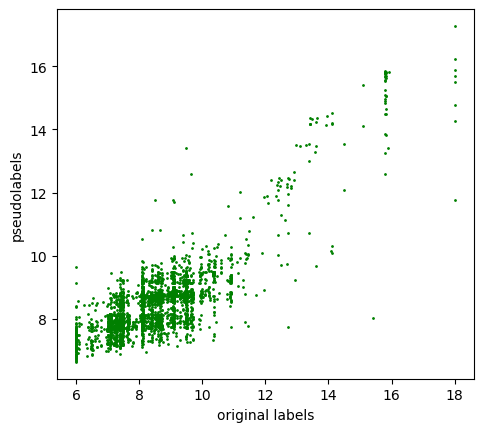

id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,7.942954945199048,7.5,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,11.699141570094367,13.533,40.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.725,0,0
2,6.960889243287137,3.71,5.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.75,0,0
3,8.658152813077118,8.7,8.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.67,0,0
4,8.563899514967467,8.05,8.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.4,0,0
5,8.766040495662935,9.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.4,0,0
6,8.133953748854644,7.5,8.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
7,7.979739768172051,7.35,8.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [9]:
%%time
submission = sample_submission.copy()
submission = apply_rf_pseudolabeling(submission, features=features)

plt.scatter(sample_submission.target, submission.target, s=1, c='g')
plt.gca().set_aspect('equal')
plt.xlabel('original labels')
plt.ylabel('pseudolabels')
plt.show()

submission.to_csv('submission.csv')
!head submission.csv
